In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Import first set of data
import os

# Read CSV file
df_sourcefile = pd.read_csv('./input/1st-employee-data-set.csv')
# df_sourcefile = pd.read_csv('./input/10-features-data.csv')
print("Shape of dataframe is: {}".format(df_sourcefile.shape))

# Make a copy of the original sourcefile
df_first_set = df_sourcefile.copy()
# Dataset columns
df_first_set.columns
# Dataset header
df_first_set.head()

# Columns datatypes and missign values
df_first_set.info()

Shape of dataframe is: (735, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       735 non-null    int64 
 1   Attrition                 735 non-null    object
 2   BusinessTravel            735 non-null    object
 3   DailyRate                 735 non-null    int64 
 4   Department                735 non-null    object
 5   DistanceFromHome          735 non-null    int64 
 6   Education                 735 non-null    int64 
 7   EducationField            735 non-null    object
 8   EmployeeCount             735 non-null    int64 
 9   EmployeeNumber            735 non-null    int64 
 10  EnvironmentSatisfaction   735 non-null    int64 
 11  Gender                    735 non-null    object
 12  HourlyRate                735 non-null    int64 
 13  JobInvolvement            735 non-null    int64

In [3]:
# 3 steps of pre-processing data

# 1. Encoding
# Machine Learning algorithms can typically only have numerical values as their predictor variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()
print(df_first_set.shape)
df_first_set.head()

(735, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df_first_set.columns[1:]:
    if df_first_set[col].dtype == 'object':
        if len(list(df_first_set[col].unique())) <= 2:
            le.fit(df_first_set[col])
            df_first_set[col] = le.transform(df_first_set[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

# convert rest of categorical variable into dummy
df_first_set = pd.get_dummies(df_first_set, drop_first=True)
print(df_first_set.shape)
df_first_set.head()

4 columns were label encoded.
(735, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [5]:
# 2. Feature scaling
# Feature Scaling using MinMaxScaler essentially shrinks the range such that the range is now between 0 and n. 
# Machine Learning algorithms perform better when input numerical variables fall within a similar scale. 
# In this case, we are scaling between 0 and 5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
first_set_col = list(df_first_set.columns)
first_set_col.remove('Attrition')
for col in first_set_col:
    df_first_set[col] = df_first_set[col].astype(float)
    df_first_set[[col]] = scaler.fit_transform(df_first_set[[col]])
df_first_set['Attrition'] = pd.to_numeric(df_first_set['Attrition'], downcast='float')
df_first_set.head()
print('Size of Full Encoded Dataset: {}'. format(df_first_set.shape))

Size of Full Encoded Dataset: (735, 49)


In [6]:
# 3. Splitting data into training and testing sets

# assign the target to a new dataframe and convert it to a numerical feature
target = df_first_set['Attrition'].copy()
# remove the target feature and redundant features from the dataset
# df_first_set.drop(['Attrition'], axis=1, inplace=True)
df_first_set.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber',
            'StandardHours', 'Over18'], axis=1, inplace=True)

# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_first_set,
                                                    target,
                                                    test_size=0.20,
                                                    random_state=3,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (588, 44)
Number transactions y_train dataset:  (588,)
Number transactions X_test dataset:  (147, 44)
Number transactions y_test dataset:  (147,)


In [7]:
# Leverage random forrest model to get feature importance


rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=3)
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=2)


grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

best params: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, random_state=3)
best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
best score: 0.7756541531007738


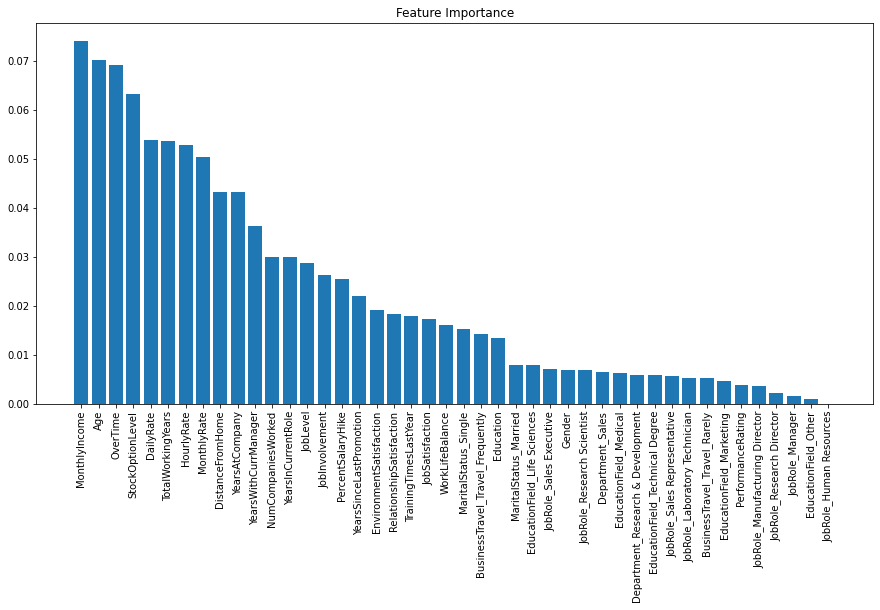

In [8]:
# Finding feature importance
import matplotlib.pyplot as plt
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [9]:
# Identify top 10 indicators which affect employee churn
importances = rf_opt.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(44):
# for i in range(10):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,MonthlyIncome,0.074126
1,Age,0.070286
2,OverTime,0.069286
3,StockOptionLevel,0.063361
4,DailyRate,0.054030
5,TotalWorkingYears,0.053780
6,HourlyRate,0.052935
7,MonthlyRate,0.050492
8,DistanceFromHome,0.043399
9,YearsAtCompany,0.043327


Accuracy of RandomForest Regression Classifier on test set: 88.44


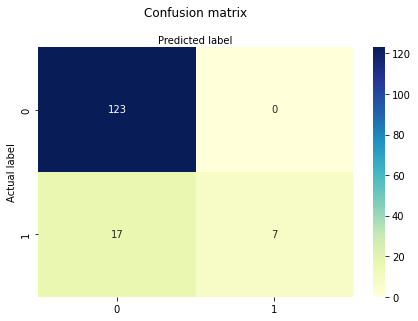

In [10]:
# Evaluation on model outcome
# sklearn modules for performance metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score
import seaborn as sns

## Confusion Matrix
# The Confusion matrix provides us with a much more detailed representation of the accuracy score 
# and of what's going on with our labels - we know exactly which/how labels were correctly and incorrectly predicted
cnf_matrix = metrics.confusion_matrix(y_test, rf_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy of RandomForest Regression Classifier on test set: {:.2f}'.format(rf_opt.score(X_test, y_test)*100))

In [11]:
# Classification report for the optimised RF Regression
rf_opt.fit(X_train, y_train)
print(classification_report(y_test, rf_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       123
         1.0       1.00      0.29      0.45        24

    accuracy                           0.88       147
   macro avg       0.94      0.65      0.69       147
weighted avg       0.90      0.88      0.86       147



In [12]:
# Finding AUC score
rf_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = rf_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
rf_opt_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.810


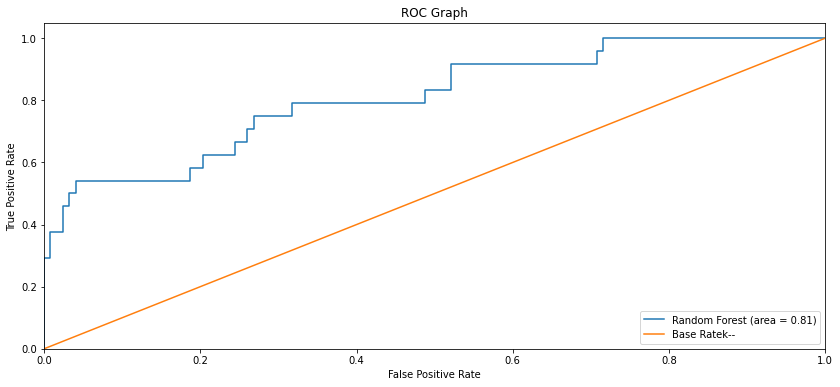

In [13]:
# Create ROC Graph

# AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
# ROC is a probability curve and 
# AUC represents degree or measure of separability. 
# It tells how much model is capable of distinguishing between classes. 
# The green line represents the ROC curve of a purely random classifier; 
# a good classifier stays as far away from that line as possible (toward the top-left corner).


from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()